In [2]:
!pip install -q tensorflow
!pip install -q scikit-learn seaborn matplotlib opencv-python

In [3]:
!pip install -q numpy

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os, shutil, zipfile, random
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image

In [5]:
# Define Model Paths (Colab Version)
import os

# Base path to your project folder in Google Drive
drive_project_path = "/content/drive/MyDrive/DeepLearningProject"

# Directory within your project folder for saving models
model_save_dir = os.path.join(drive_project_path, "models") # Changed path
os.makedirs(model_save_dir, exist_ok=True) # Ensure directory exists

# Filenames for the models (these can stay the same)
cnn_model_filename = "best_custom_cnn_model.keras"
mobilenet_model_filename = "best_mobilenet_model.keras"

# Full paths (os.path.join works correctly)
cnn_model_path = os.path.join(model_save_dir, cnn_model_filename)
mobilenet_model_path = os.path.join(model_save_dir, mobilenet_model_filename)

print(f"Custom CNN model will be saved/loaded from: {cnn_model_path}")
print(f"MobileNetV2 model will be saved/loaded from: {mobilenet_model_path}")

Custom CNN model will be saved/loaded from: /content/drive/MyDrive/DeepLearningProject/models/best_custom_cnn_model.keras
MobileNetV2 model will be saved/loaded from: /content/drive/MyDrive/DeepLearningProject/models/best_mobilenet_model.keras


In [6]:
# Verify GPU access
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
import zipfile, os

zip_path = "/content/drive/MyDrive/DeepLearningProject/archive.zip"
extract_path = "/content/plantvillage"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("✅ Dataset extracted successfully!")

# Verify extraction
os.listdir(extract_path)[:10]


✅ Dataset extracted successfully!


['plantvillage dataset']

In [8]:
from PIL import Image
import os

def remove_corrupt_images(root_dir):

    removed = 0
    for root, _, files in os.walk(root_dir):
        for f in files:
            path = os.path.join(root, f)
            try:
                # Try to open the image
                img = Image.open(path)
                img.verify()  # verifies the file without loading into memory
            except Exception:
                try:
                    os.remove(path)
                    removed += 1
                except:
                    pass
    print(f"✅ Scan complete — removed {removed} corrupt or unreadable files.")


In [9]:
import os, shutil

# ✅ Base path (local extracted dataset)
base_path = "/content/plantvillage/plantvillage dataset"

# Subfolders — adjust names if your zip contains folders named differently
color_path = os.path.join(base_path, "color")
gray_path = os.path.join(base_path, "grayscale")
seg_path = os.path.join(base_path, "segmented")

# Destination folder for merged dataset
merged_path = os.path.join(base_path, "combined_dataset")
os.makedirs(merged_path, exist_ok=True)

def merge_datasets(source_dirs, dest_dir):
    for source in source_dirs:
        if not os.path.exists(source):
            print(f"⚠️ Skipped (not found): {source}")
            continue
        for class_name in os.listdir(source):
            class_dir = os.path.join(source, class_name)
            if os.path.isdir(class_dir):
                dest_class_dir = os.path.join(dest_dir, class_name)
                os.makedirs(dest_class_dir, exist_ok=True)
                for img_file in os.listdir(class_dir):
                    src_file = os.path.join(class_dir, img_file)
                    dest_file = os.path.join(dest_class_dir, img_file)
                    if not os.path.exists(dest_file):
                        shutil.copy(src_file, dest_file)
    print("✅ All dataset variants merged successfully!")

# Run the merge process
merge_datasets([color_path, gray_path, seg_path], merged_path)


✅ All dataset variants merged successfully!


In [10]:
# Cell 8 (NEW): Add this function CALL
remove_corrupt_images(merged_path)

✅ Scan complete — removed 0 corrupt or unreadable files.


In [11]:
# 1. Create a generator for TRAINING data with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # We still need this to split the files correctly
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 2. Create a generator for VALIDATION data with ONLY rescaling (NO augmentation)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Must be the same split to avoid data overlap
)

# 3. Use the train_datagen for the training set
train_set = train_datagen.flow_from_directory(
    merged_path,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
    subset='training'  # This gets the 80% of data for training
)

# 4. Use the val_datagen for the validation set
val_set = val_datagen.flow_from_directory(
    merged_path,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
    subset='validation'  # This gets the remaining 20% for validation
)

Found 86904 images belonging to 38 classes.
Found 21707 images belonging to 38 classes.


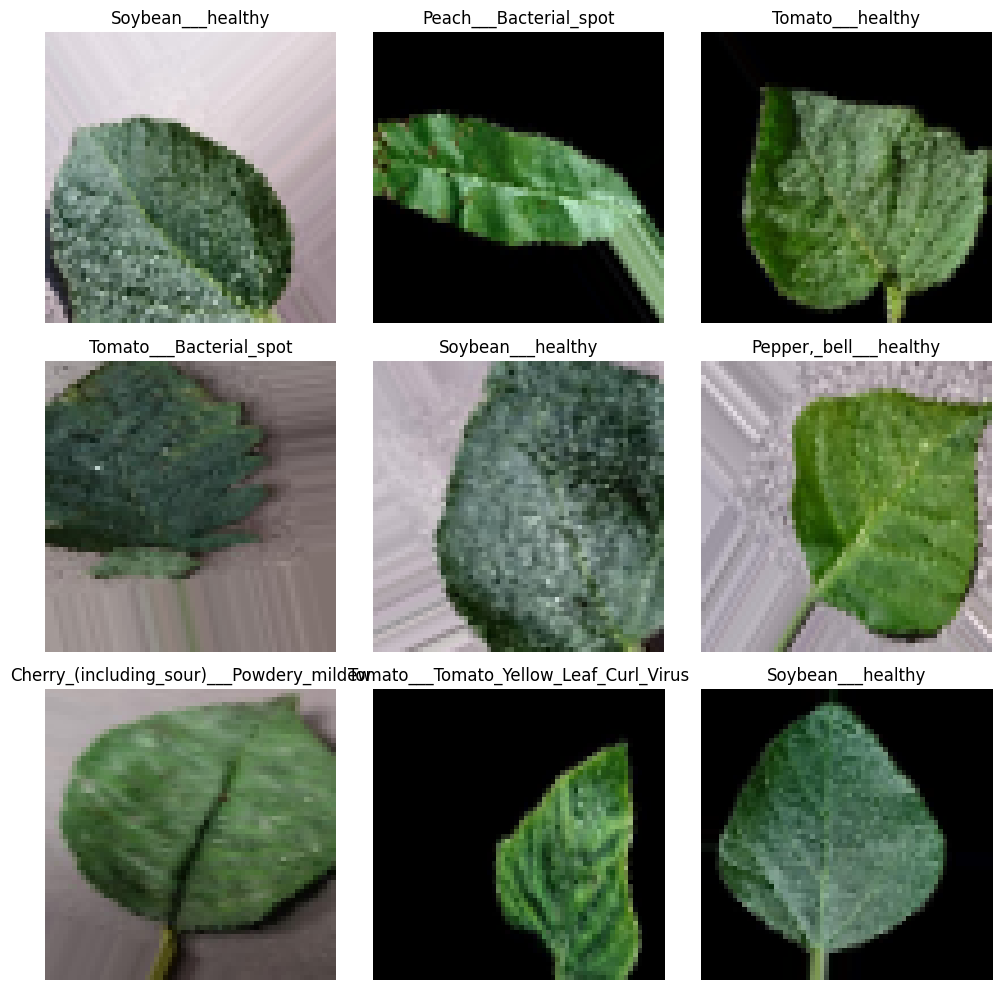

In [12]:
# NEW CODE: Visualize a sample of training images
images, labels = next(train_set)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(list(train_set.class_indices.keys())[np.argmax(labels[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [13]:
from collections import Counter

# Get class names from the generator
class_names = list(train_set.class_indices.keys())

# --- Get TRAINING set counts ---
# 'train_set.classes' lists the class index for every training image
train_counts = Counter(train_set.classes)
print("✅ Class distribution in the TRAINING set (80%):")
for i in range(len(class_names)):
    # Find the class name that corresponds to index 'i' and print its count
    class_name = class_names[i]
    print(f"{class_name}: {train_counts[i]} images")

print("\n" + "="*30 + "\n")

# --- Get VALIDATION set counts ---
# 'val_set.classes' lists the class index for every validation image
val_counts = Counter(val_set.classes)
print("✅ Class distribution in the VALIDATION set (20%):")
for i in range(len(class_names)):
    class_name = class_names[i]
    print(f"{class_name}: {val_counts[i]} images")

✅ Class distribution in the TRAINING set (80%):
Apple___Apple_scab: 1008 images
Apple___Black_rot: 994 images
Apple___Cedar_apple_rust: 440 images
Apple___healthy: 2632 images
Blueberry___healthy: 2404 images
Cherry_(including_sour)___Powdery_mildew: 1684 images
Cherry_(including_sour)___healthy: 1367 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 821 images
Corn_(maize)___Common_rust_: 1908 images
Corn_(maize)___Northern_Leaf_Blight: 1576 images
Corn_(maize)___healthy: 1860 images
Grape___Black_rot: 1888 images
Grape___Esca_(Black_Measles): 2214 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1722 images
Grape___healthy: 677 images
Orange___Haunglongbing_(Citrus_greening): 8812 images
Peach___Bacterial_spot: 3676 images
Peach___healthy: 576 images
Pepper,_bell___Bacterial_spot: 1596 images
Pepper,_bell___healthy: 2365 images
Potato___Early_blight: 1600 images
Potato___Late_blight: 1600 images
Potato___healthy: 244 images
Raspberry___healthy: 594 images
Soybean___healthy

In [14]:
# Optional: Visualize the distribution
df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
plt.figure(figsize=(15, 8))
sns.barplot(x='Class', y='Count', data=df)
plt.xticks(rotation=90)
plt.title('Distribution of Images per Class')
plt.show()

NameError: name 'class_counts' is not defined

In [ ]:
# Step 5: Model Development - CNN Architecture

# Import necessary modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input

# Define the improved CNN model architecture
model = Sequential([
    Input(shape=(64, 64, 3)),  # You can change to (64,64,3) if GPU is limited

    # Convolutional Block 1
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten + Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output Layer (Softmax for multi-class classification)
    Dense(train_set.num_classes, activation='softmax')
])

# Display model summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688,998 (2.63 MB)

 Trainable params: 688,550 (2.63 MB)

 Non-trainable params: 448 (1.75 KB)

--- Training Custom CNN Model ---
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5431/5432 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2214 - loss: 3.0691
Epoch 1: val_accuracy improved from -inf to 0.33828, saving model to /content/drive/MyDrive/DeepLearningProject/models/best_custom_cnn_model.keras
5432/5432 ━━━━━━━━━━━━━━━━━━━━ 218s 39ms/step - accuracy: 0.2214 - loss: 3.0690 - val_accuracy: 0.3383 - val_loss: 2.3667
Epoch 2/20
5431/5432 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3969 - loss: 2.1538
Epoch 2: val_accuracy improved from 0.33828 to 0.52522, saving model to /content/drive/MyDrive/DeepLearningProject/models/best_custom_cnn_model.keras
5432/5432 ━━━━━━━━━━━━━━━━━━━━ 210s 39ms/step - accuracy: 0.3969 - loss: 2.1538 - val_accuracy: 0.5252 - val_loss: 1.5566
Epoch 3/20
5432/5432 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5154 - loss: 1.6762
Epoch 3: val_accuracy improved from 0.52522 to 0.62712, saving model to /content/drive/MyDrive/DeepLearningProject/models/best_custom_cnn_model.keras
5432/5432 ━━━━━━━━━━━━━━━━━━━━ 207s 38ms/step - accur

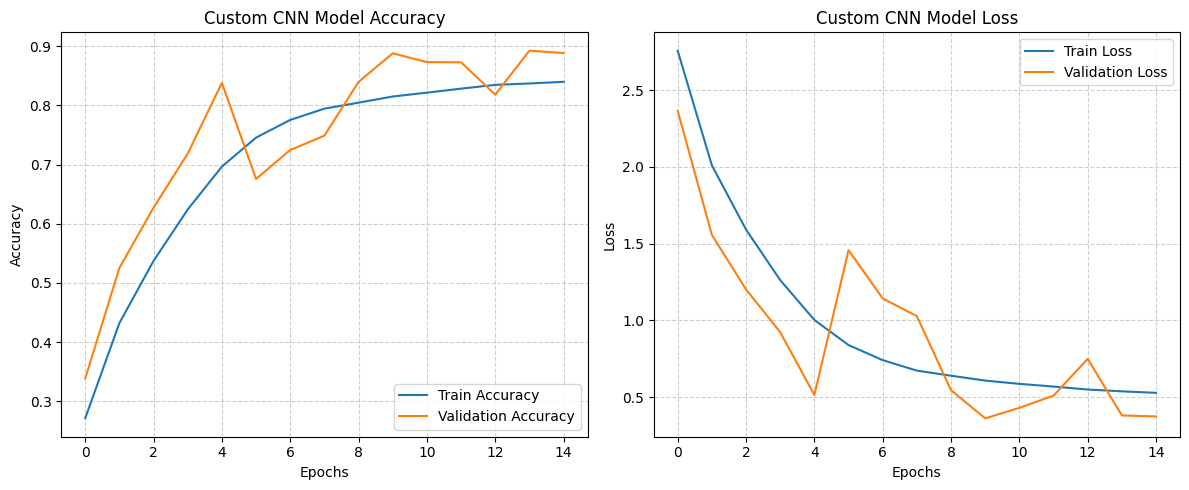


--- Evaluating Custom CNN Model ---
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.8846 - loss: 0.3633
✅ Validation Accuracy (Best Epoch based on Val Loss): 88.79%
✅ Best model (based on Val Accuracy) saved during training at: /content/drive/MyDrive/DeepLearningProject/models/best_custom_cnn_model.keras


In [ ]:
# Cell 13: Model Compilation and Training (Custom CNN - Updated)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os

# --- Compile the model ---
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_cnn = ModelCheckpoint( # Changed variable name for clarity
    filepath=cnn_model_path,      # Use the variable defined earlier
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1                     # Added verbose=1 to see when the model saves
)

# --- Train the model ---
print("--- Training Custom CNN Model ---")
history_cnn = model.fit(            # Changed history variable name
    train_set,
    validation_data=val_set,
    epochs=20,                      # Kept original 20, reduce to 5 for quick testing if needed
    callbacks=[early_stop, checkpoint_cnn] # Use updated checkpoint variable
)

# --- Plot accuracy and loss ---
print("\n--- Plotting Custom CNN Training History ---")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Use history_cnn variable below
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Custom CNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6) # Added grid for readability

plt.subplot(1, 2, 2)
# Use history_cnn variable below
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Custom CNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6) # Added grid for readability

plt.tight_layout() # Added for better spacing
plt.show()

# --- Evaluate on validation set ---
print("\n--- Evaluating Custom CNN Model ---")
# Note: Since EarlyStopping has restore_best_weights=True,
# this evaluation uses the weights from the best epoch based on val_loss.
val_loss, val_acc = model.evaluate(val_set)
print(f"✅ Validation Accuracy (Best Epoch based on Val Loss): {val_acc * 100:.2f}%")

# Use the variable defined earlier for the saved model path
print(f"✅ Best model (based on Val Accuracy) saved during training at: {cnn_model_path}")

In [15]:
# --- Load Pre-Trained CNN Model ---
# Instead of re-training, we load the best model saved to Google Drive
# (from the previous run) to continue with evaluation.
from tensorflow.keras.models import load_model

# This path variable must be defined by running the "Define Model Paths" cell first
print(f"Loading saved model from: {cnn_model_path}")

model = load_model(cnn_model_path)

print("✅ Model loaded successfully!")
model.summary() # Optional, but good to confirm it loaded

Loading saved model from: /content/drive/MyDrive/DeepLearningProject/models/best_custom_cnn_model.keras
✅ Model loaded successfully!


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,066,100 (7.88 MB)

 Trainable params: 688,550 (2.63 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 1,377,102 (5.25 MB)

Found 21707 images belonging to 38 classes.
--- Generating predictions on validation set (unshuffled) ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1357/1357 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step
Predictions shape: (21707, 38)
Predicted indices: (21707,)
True indices: (21707,)

📊 Classification Report (Validation Set):

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab      0.938     0.718     0.813       252
                                 Apple___Black_rot      0.942     0.859     0.899       248
                          Apple___Cedar_apple_rust      0.989     0.791     0.879       110
                                   Apple___healthy      0.830     0.874     0.851       658
                               Blueberry___healthy      0.981     0.883     0.930       600
          Cherry_(including_sour)___Powdery_mildew      0.986     0.819     0.895       420
                 Cherry_(including_sour)___healthy      0.950     0.883     0.915       341
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot      0.722     0.824     0.770       205


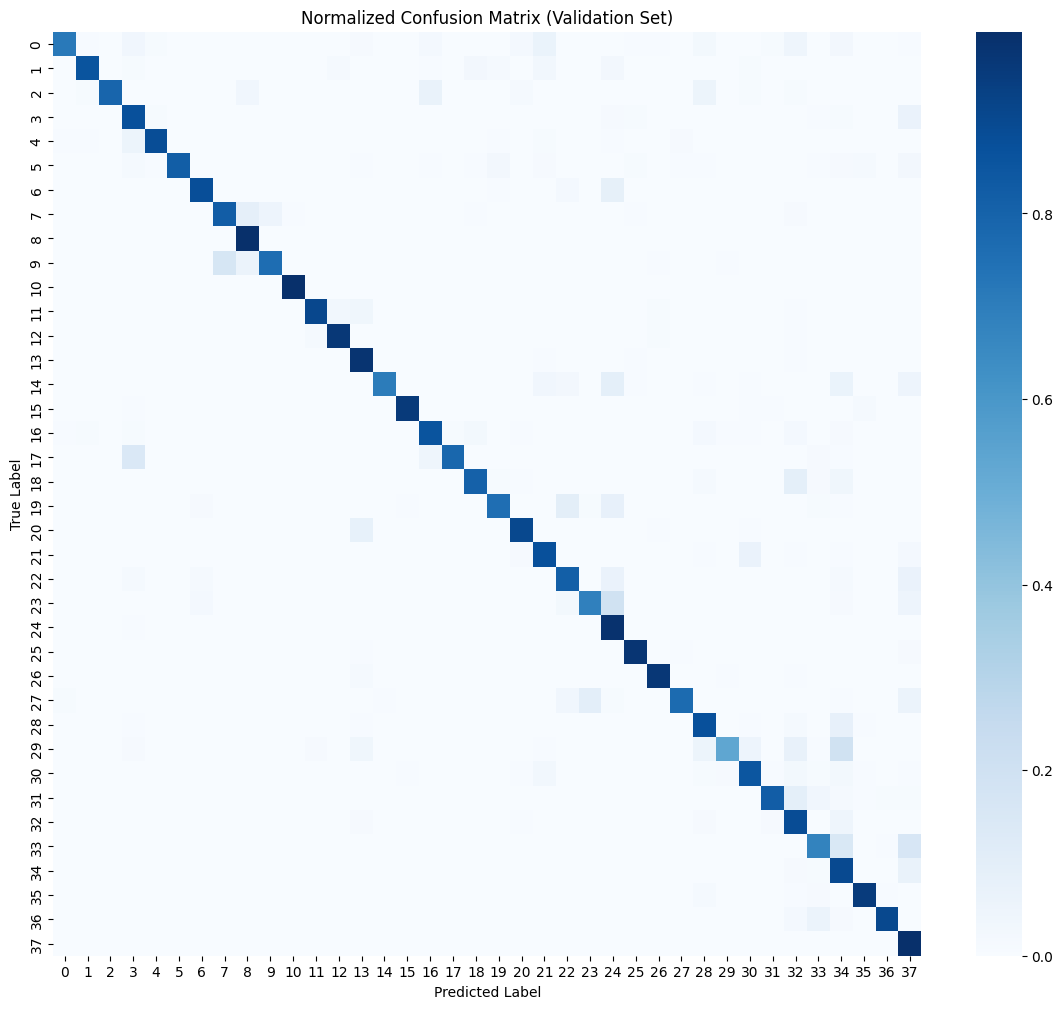

In [16]:
# Cell 15: Model Evaluation (Classification Report + Confusion Matrix)

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create a generator for EVALUATION (rescale only)
eval_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Must match the split used in training
)

# 2. Create the non-shuffled generator from the validation subset
eval_generator = eval_datagen.flow_from_directory(
    merged_path,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # <-- The critical change!
)

# 3. Get predictions and true labels (now in the same order)
print("--- Generating predictions on validation set (unshuffled) ---")
# This will iterate through eval_generator in order
val_preds = model.predict(eval_generator, verbose=1)
y_pred = np.argmax(val_preds, axis=1)
y_true = eval_generator.classes  # <-- Get labels from the non-shuffled generator
class_labels = list(eval_generator.class_indices.keys())

# --- The rest of your code is perfect ---
print(f"Predictions shape: {val_preds.shape}")
print(f"Predicted indices: {y_pred.shape}")
print(f"True indices: {y_true.shape}")

print("\n📊 Classification Report (Validation Set):\n")
report = classification_report(y_true, y_pred, target_names=class_labels, digits=3)
print(report)

print("\n📊 Confusion Matrix (Validation Set):")
cm = confusion_matrix(y_true, y_pred)
# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_normalized, cmap='Blues') # Plot the normalized matrix
plt.title('Normalized Confusion Matrix (Validation Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


🖼️ Testing on: /content/plantvillage/plantvillage dataset/combined_dataset/Grape___Black_rot/00905d40-bddf-460e-b348-1dbb6a34653b___FAM_B.Rot 0664_final_masked.jpg

🖼️ Testing on: /content/plantvillage/plantvillage dataset/combined_dataset/Tomato___Spider_mites Two-spotted_spider_mite/0c2e84df-4d41-46f6-9cf9-05aea349ce18___Com.G_SpM_FL 1142_final_masked.jpg

🖼️ Testing on: /content/plantvillage/plantvillage dataset/combined_dataset/Soybean___healthy/50f595fb-030e-4351-a801-431de6a38e84___RS_HL 4447_final_masked.jpg

🖼️ Testing on: /content/plantvillage/plantvillage dataset/combined_dataset/Peach___healthy/829cd2af-ecf8-487d-a1b2-ed8a210ae18e___Rutg._HL 2416_final_masked.jpg

🖼️ Testing on: /content/plantvillage/plantvillage dataset/combined_dataset/Apple___Apple_scab/f1017472-d391-4a66-b9b2-d52916cd0c0b___FREC_Scab 3176_final_masked.jpg


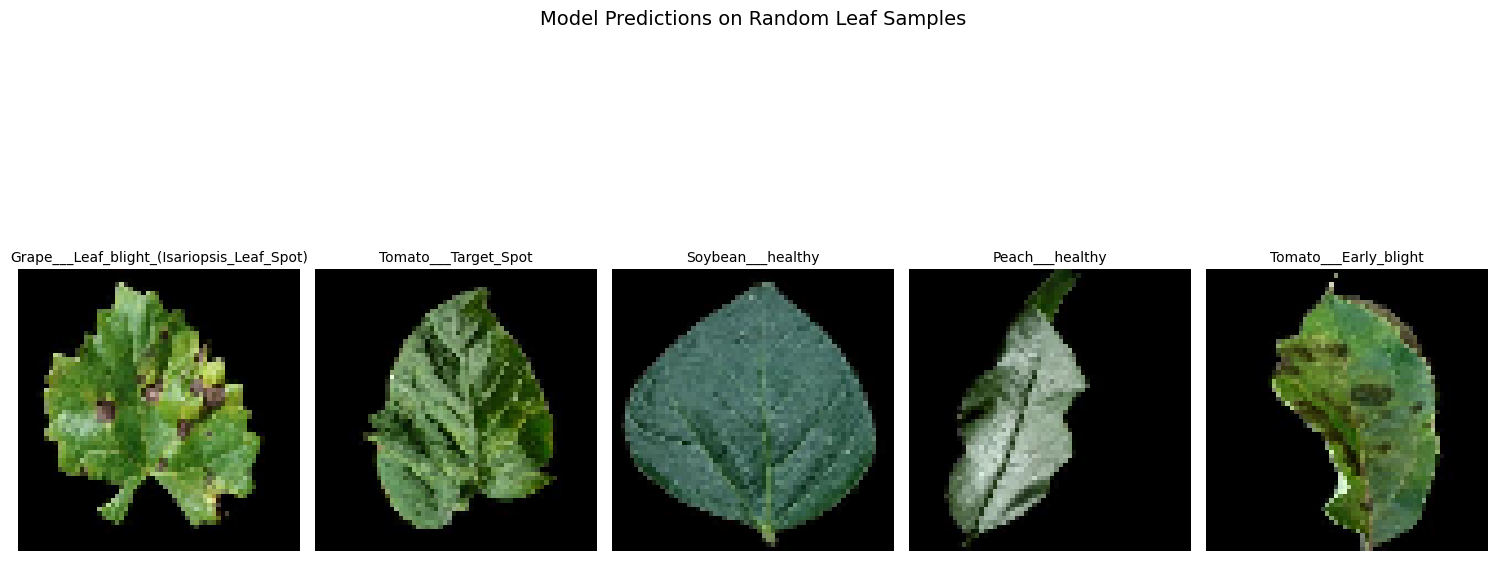

In [27]:
# Step 8: Visualize Random Predictions (Healthy vs Diseased)

import random
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

num_samples = 5
DATA_DIR = merged_path

all_classes = os.listdir(DATA_DIR)
sampled_classes = random.sample(all_classes, num_samples)

plt.figure(figsize=(15, 8))

for i, cls in enumerate(sampled_classes):
    class_dir = os.path.join(DATA_DIR, cls)
    img_name = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_name)
    print(f"\n🖼️ Testing on: {img_path}")

    img = image.load_img(img_path, target_size=(64, 64))  # Match model input
    img_array = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)

    preds = model.predict(img_array, verbose=0)
    class_dict = {v: k for k, v in train_set.class_indices.items()}
    predicted_label = class_dict[np.argmax(preds)]

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(predicted_label, fontsize=10)

# --- START OF CHANGES ---
plt.suptitle("Model Predictions on Random Leaf Samples", fontsize=14, y=0.98) # Adjusted y-value
plt.subplots_adjust(top=0.85) # Explicitly adjust the top margin
# --- END OF CHANGES ---

plt.tight_layout() # Keep this, but it will work better with subplots_adjust
plt.show()

--- Top Performing Classes (F1-Score) ---


,Class,Precision,Recall,F1-Score
10,Corn_(maize)___healthy,0.997835,0.993534,0.995680
15,Orange___Haunglongbing_(Citrus_greening),0.996207,0.954133,0.974716
25,Squash___Powdery_mildew,0.972789,0.974114,0.973451
26,Strawberry___Leaf_scorch,0.955457,0.968397,0.961883
35,Tomato___Tomato_Yellow_Leaf_Curl_Virus,0.971851,0.950980,0.961303
12,Grape___Esca_(Black_Measles),0.960289,0.962025,0.961156
24,Soybean___healthy,0.929298,0.987721,0.957619
8,Corn_(maize)___Common_rust_,0.908046,0.995798,0.949900
11,Grape___Black_rot,0.957494,0.906780,0.931447
4,Blueberry___healthy,0.981481,0.883333,0.929825



--- Bottom Performing Classes (F1-Score) ---


,Class,Precision,Recall,F1-Score
27,Strawberry___healthy,0.880503,0.769231,0.821114
37,Tomato___healthy,0.698675,0.995283,0.821012
0,Apple___Apple_scab,0.937824,0.718254,0.813483
32,Tomato___Septoria_leaf_spot,0.751196,0.887006,0.813472
7,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,0.722222,0.824390,0.769932
33,Tomato___Spider_mites Two-spotted_spider_mite,0.820976,0.677612,0.742437
23,Raspberry___healthy,0.796875,0.689189,0.739130
34,Tomato___Target_Spot,0.566629,0.901961,0.696011
29,Tomato___Early_blight,0.895397,0.535000,0.669797
22,Potato___healthy,0.337931,0.816667,0.478049


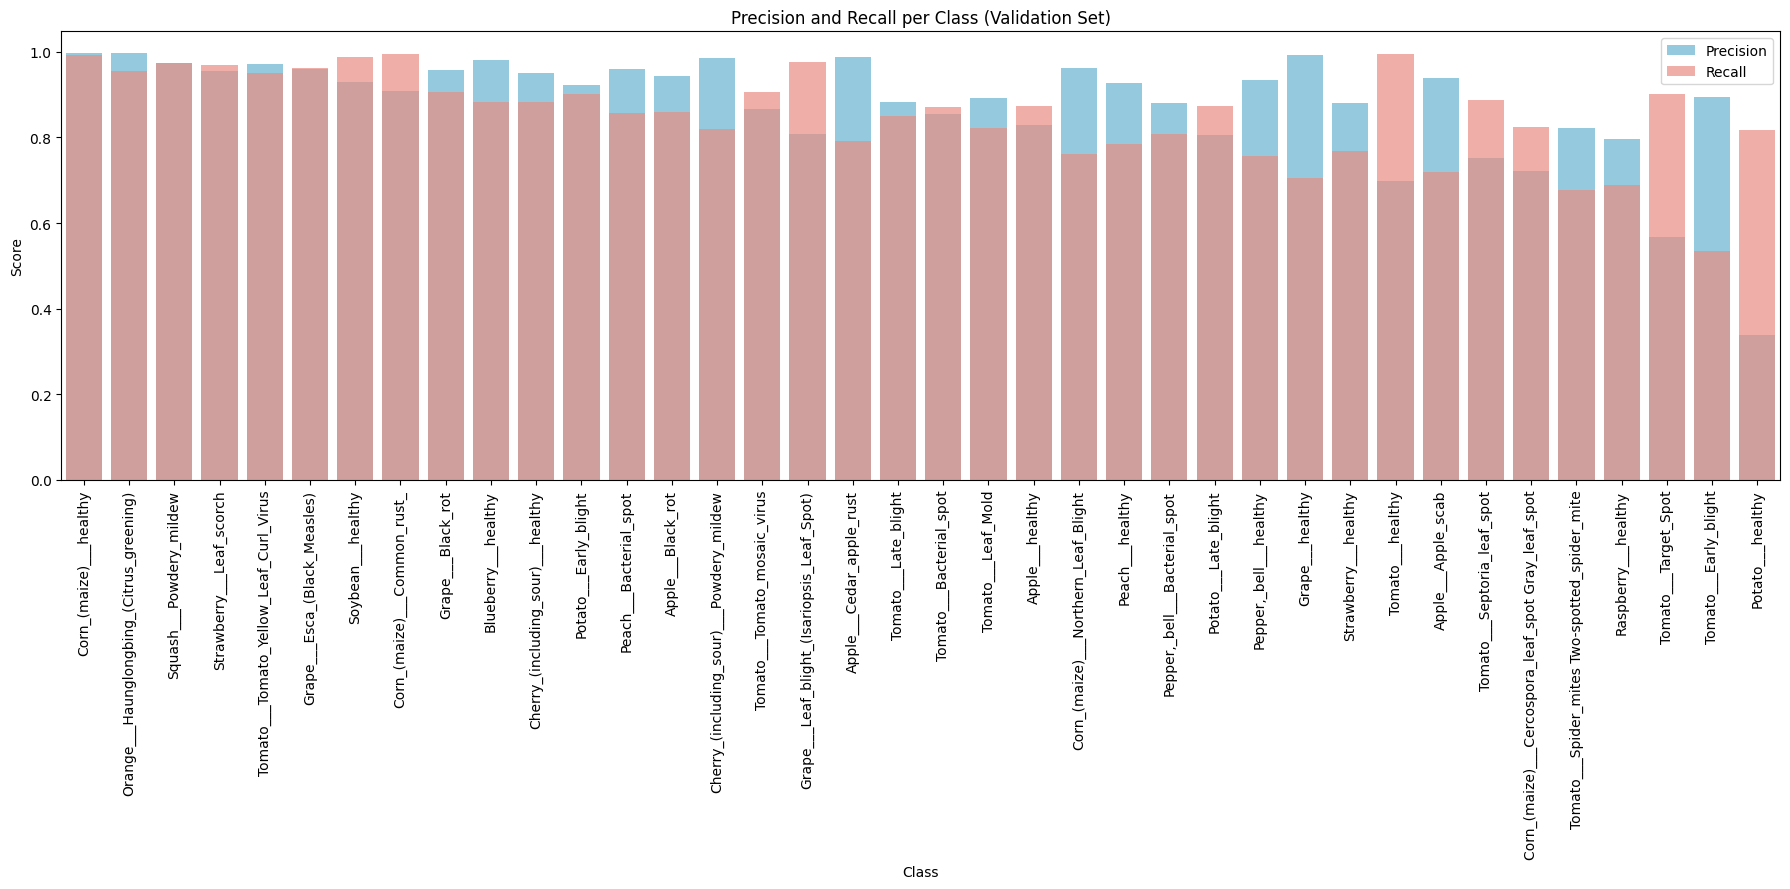

In [30]:
# Step 9: Detailed Evaluation – Precision, Recall, F1 per Class

from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure previous predictions exist
if 'y_true' not in locals() or 'y_pred' not in locals() or 'class_labels' not in locals():
    raise NameError("Run the evaluation cell (Cell 15) first — prediction variables not found.")

# Compute metrics per class
metrics = precision_recall_fscore_support(
    y_true, y_pred, average=None, labels=np.arange(len(class_labels))
)

# Create DataFrame
metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': metrics[0],
    'Recall': metrics[1],
    'F1-Score': metrics[2]
}).sort_values(by='F1-Score', ascending=False)

# Display top/bottom classes
print("--- Top Performing Classes (F1-Score) ---")
display(metrics_df.head(10))
print("\n--- Bottom Performing Classes (F1-Score) ---")
display(metrics_df.tail(10))

# Visualization
plt.figure(figsize=(18, 9))
sns.barplot(x='Class', y='Precision', data=metrics_df, color='skyblue', label='Precision')
sns.barplot(x='Class', y='Recall', data=metrics_df, color='salmon', alpha=0.7, label='Recall')
plt.xticks(rotation=90)
plt.ylabel('Score')
plt.title('Precision and Recall per Class (Validation Set)')
plt.legend()
plt.tight_layout()
plt.show()


✅ Correct predictions: 19369
❌ Incorrect predictions: 2338
--- (Calculated Accuracy: 89.23%) ---


/tmp/ipython-input-1236732729.py:49: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1236732729.py:49: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


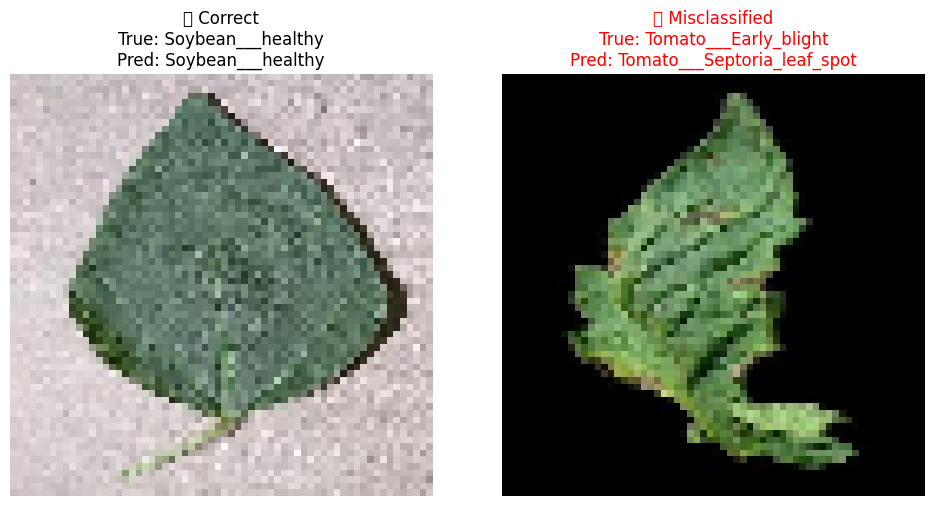

In [32]:
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Ensure all required variables exist
if 'y_true' not in locals() or 'y_pred' not in locals() or 'eval_generator' not in locals() or 'class_labels' not in locals():
    raise NameError("Run the evaluation cell (Cell 15) first — missing variables.")

# Find correct and incorrect predictions
correct_indices = np.where(y_pred == y_true)[0]
incorrect_indices = np.where(y_pred != y_true)[0]

print(f"✅ Correct predictions: {len(correct_indices)}")
print(f"❌ Incorrect predictions: {len(incorrect_indices)}")
print(f"--- (Calculated Accuracy: {len(correct_indices) / len(y_true) * 100:.2f}%) ---")


# Randomly select one correct and one incorrect example
correct_idx = random.choice(correct_indices) if len(correct_indices) > 0 else None
incorrect_idx = random.choice(incorrect_indices) if len(incorrect_indices) > 0 else None

plt.figure(figsize=(10, 5))

# Correctly classified image
if correct_idx is not None:
    # --- FIX: Use eval_generator.filepaths ---
    img_path = eval_generator.filepaths[correct_idx]
    true_label = class_labels[y_true[correct_idx]]
    pred_label = class_labels[y_pred[correct_idx]]

    plt.subplot(1, 2, 1)
    plt.imshow(image.load_img(img_path, target_size=(64, 64)))
    plt.title(f"✅ Correct\nTrue: {true_label}\nPred: {pred_label}")
    plt.axis("off")

# Misclassified image
if incorrect_idx is not None:
    # --- FIX: Use eval_generator.filepaths ---
    img_path = eval_generator.filepaths[incorrect_idx]
    true_label = class_labels[y_true[incorrect_idx]]
    pred_label = class_labels[y_pred[incorrect_idx]]

    plt.subplot(1, 2, 2)
    plt.imshow(image.load_img(img_path, target_size=(64, 64)))
    plt.title(f"❌ Misclassified\nTrue: {true_label}\nPred: {pred_label}", color='red')
    plt.axis("off")

plt.tight_layout()
plt.show()

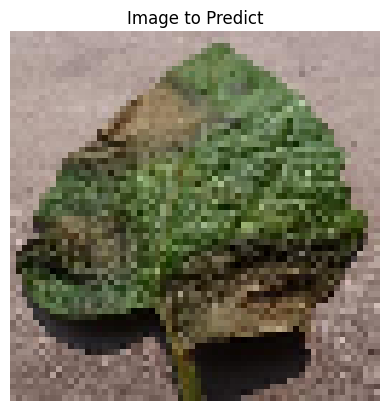

🌿 Predicted Disease: Potato___Late_blight (86.22% confidence)


('Potato___Late_blight', np.float32(86.21731))

In [33]:
# ✅ Step 11: Predict Plant Disease from a New Image

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Use class labels from the training set
class_labels = list(train_set.class_indices.keys())

def predict_plant_disease(image_path, model, class_labels, target_size=(64, 64)):
    """Predicts plant disease from an image using the trained CNN model."""
    try:
        img = image.load_img(image_path, target_size=target_size)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Image to Predict")
        plt.show()

        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        predictions = model.predict(img_array, verbose=0)
        predicted_idx = np.argmax(predictions)
        confidence = np.max(predictions) * 100
        predicted_label = class_labels[predicted_idx]

        print(f"🌿 Predicted Disease: {predicted_label} ({confidence:.2f}% confidence)")
        return predicted_label, confidence

    except FileNotFoundError:
        print("❌ Image not found at the specified path.")
        return None, None
    except Exception as e:
        print(f"⚠️ Error: {e}")
        return None, None


# 🧪 Example: change path to test different images
img_to_predict = "/content/plantvillage/plantvillage dataset/color/Tomato___Late_blight/00355ec2-f12c-4015-b8f9-94354f69ce22___RS_Late.B 5311.JPG"

predict_plant_disease(img_to_predict, model, class_labels)


✅ Loaded model: Sequential
✅ Functional model created. Last Conv2D layer: conv2d_5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
✅ Grad-CAM model built successfully.
✅ Image loaded: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
🌿 Predicted: Potato___Late_blight (86.22% confidence)


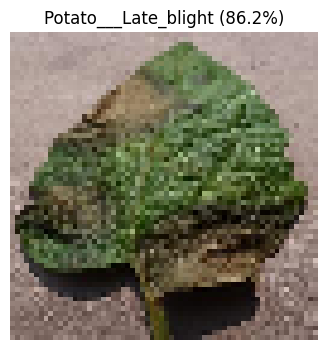

In [34]:
# ✅ Step 12: Grad-CAM Visualization for Custom CNN
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input
import numpy as np, cv2, matplotlib.pyplot as plt, os

# 1️⃣ Load trained CNN model
base_model = load_model(cnn_model_path)
print("✅ Loaded model:", base_model.__class__.__name__)

# 2️⃣ Build functional model to capture the last Conv2D layer
inp = Input(shape=(64, 64, 3))
x = inp
last_conv_tensor, last_conv_name = None, None

for layer in base_model.layers:
    x = layer(x)
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_tensor, last_conv_name = x, layer.name

if last_conv_tensor is None:
    raise ValueError("No Conv2D layer found in the model.")

model_xai = Model(inputs=inp, outputs=x)
print("✅ Functional model created. Last Conv2D layer:", last_conv_name)

# 3️⃣ Warm-up model
_ = model_xai.predict(np.zeros((1, 64, 64, 3), dtype=np.float32))

# 4️⃣ Build Grad-CAM helper model
grad_model = Model(inputs=inp, outputs=[last_conv_tensor, x])
print("✅ Grad-CAM model built successfully.")

# 5️⃣ Load and preprocess test image
img_path = "/content/plantvillage/plantvillage dataset/color/Tomato___Late_blight/00355ec2-f12c-4015-b8f9-94354f69ce22___RS_Late.B 5311.JPG"
orig_img = tf.keras.utils.load_img(img_path, target_size=(64, 64))
orig_img_array = tf.keras.utils.img_to_array(orig_img)
img_array = np.expand_dims(orig_img_array / 255.0, axis=0)
print("✅ Image loaded:", img_array.shape)

# 6️⃣ Predict and display class
preds = model_xai.predict(img_array)
pred_class = int(np.argmax(preds[0]))
confidence = float(np.max(preds) * 100)

class_labels = list(train_set.class_indices.keys())
pred_label = class_labels[pred_class]

print(f"🌿 Predicted: {pred_label} ({confidence:.2f}% confidence)")

plt.figure(figsize=(4, 4))
plt.imshow(orig_img_array.astype("uint8"))
plt.title(f"{pred_label} ({confidence:.1f}%)")
plt.axis("off")
plt.show()


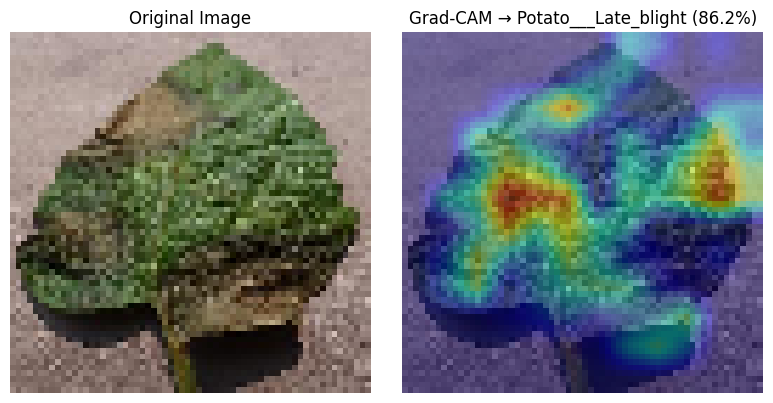

✅ Saved Grad-CAM visualization at: /content/drive/MyDrive/DeepLearningProject/GradCAM_Potato___Late_blight.jpg


In [46]:
# ✅ Step 13: Grad-CAM Heatmap Generation & Save (Custom CNN) - UPDATED
import tensorflow as tf, numpy as np, cv2, matplotlib.pyplot as plt, os

# Ensure: grad_model, img_array, orig_img_array, pred_class, pred_label, confidence exist

# 1️⃣ Compute Grad-CAM heatmap
img_tensor = tf.convert_to_tensor(img_array)
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_tensor, training=False)
    loss = predictions[:, pred_class]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
heatmap_np = heatmap.numpy()

# 2️⃣ Overlay heatmap on original image
h, w = orig_img_array.shape[:2]
heatmap_resized = cv2.resize(heatmap_np, (w, h))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
orig_bgr = cv2.cvtColor(orig_img_array.astype("uint8"), cv2.COLOR_RGB2BGR)
overlay = cv2.addWeighted(orig_bgr, 0.6, heatmap_colored, 0.4, 0)

# --- START OF CHANGES ---
# Rename variables to be unique for the comparison cell
overlay_rgb_cnn = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
# Assign the prediction/confidence from Step 12 to new 'cnn' variables
pred_label_cnn = pred_label
confidence_cnn = confidence
# --- END OF CHANGES ---


# 3️⃣ Display visualization
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(orig_img_array.astype("uint8"))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
# Use the new variable name for plotting
plt.imshow(overlay_rgb_cnn)
plt.title(f"Grad-CAM → {pred_label_cnn} ({confidence_cnn:.1f}%)") # Use new names
plt.axis("off")
plt.tight_layout()
plt.show()

# 4️⃣ Save Grad-CAM output to Drive
save_dir = "/content/drive/MyDrive/DeepLearningProject"
os.makedirs(save_dir, exist_ok=True)
# Use new variable name for saving
save_path = os.path.join(save_dir, f"GradCAM_{pred_label_cnn.replace('/', '_')}.jpg")

# Use new variable name for saving
cv2.imwrite(save_path, cv2.cvtColor(overlay_rgb_cnn, cv2.COLOR_RGB2BGR))
print("✅ Saved Grad-CAM visualization at:", save_path)

In [37]:
# ✅ Step 14: Transfer Learning with MobileNetV2 (Improved & Consistent)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import tensorflow as tf
import os
import math  # <-- ADD THIS IMPORT

# 1️⃣ Load pre-trained MobileNetV2 as feature extractor
base_model_mbn = MobileNetV2(
    input_shape=(64, 64, 3),  # 🔍 Use higher resolution for better transfer learning
    include_top=False,
    weights='imagenet'
)
base_model_mbn.trainable = False  # Freeze base model layers
print("✅ MobileNetV2 base model loaded and frozen.")

# 2️⃣ Add custom classification layers
model_mbn = Sequential([
    base_model_mbn,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_set.num_classes, activation='softmax')
])
print("✅ Classification head added successfully.")

# 3️⃣ Define learning rate scheduler (FIXED)
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        # Use Python's 'math.exp' to return a float, not a tensor
        return lr * math.exp(-0.1)

# 4️⃣ Compile model
model_mbn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("✅ Model compiled successfully.")

# 5️⃣ Ensure save path exists
try:
    mobilenet_model_path
except NameError:
    mobilenet_model_path = "/content/drive/MyDrive/DeepLearningProject/models/best_mobilenet_model.keras"
    os.makedirs(os.path.dirname(mobilenet_model_path), exist_ok=True)

# 6️⃣ Define callbacks
checkpoint_mbn = ModelCheckpoint(
    filepath=mobilenet_model_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)
early_stop_mbn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_schedule_mbn = LearningRateScheduler(scheduler, verbose=1)

# 7️⃣ Train MobileNetV2
print("\n🚀 Training MobileNetV2 Model...")
history_mbn = model_mbn.fit(
    train_set,
    validation_data=val_set,
    epochs=20,
    callbacks=[checkpoint_mbn, early_stop_mbn, lr_schedule_mbn],
    verbose=1
)

print(f"\n✅ MobileNetV2 training complete! Best model saved at:\n{mobilenet_model_path}")

#8️⃣ Optional Fine-Tuning Step (after stabilization)
base_model_mbn.trainable = True
for layer in base_model_mbn.layers[:-30]:  # Unfreeze top 30 layers only
    layer.trainable = False
model_mbn.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
print("🔧 Fine-tuning mode activated. Re-training can now continue.")

/tmp/ipython-input-2618963132.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mbn = MobileNetV2(


✅ MobileNetV2 base model loaded and frozen.
✅ Classification head added successfully.
✅ Model compiled successfully.

🚀 Training MobileNetV2 Model...

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
5432/5432 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4777 - loss: 1.9007
Epoch 1: val_accuracy improved from -inf to 0.63979, saving model to /content/drive/MyDrive/DeepLearningProject/models/best_mobilenet_model.keras
5432/5432 ━━━━━━━━━━━━━━━━━━━━ 234s 42ms/step - accuracy: 0.4777 - loss: 1.9007 - val_accuracy: 0.6398 - val_loss: 1.1856 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
5431/5432 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5781 - loss: 1.4402
Epoch 2: val_accuracy improved from 0.63979 to 0.65942, saving model to /content/drive/MyDrive/DeepLearningProject/models/best_mobilenet_model.keras
5432/5432 ━━━━━━━━━━━━━━━━━━━━ 219s 40ms/step - accuracy: 0.5781 - loss

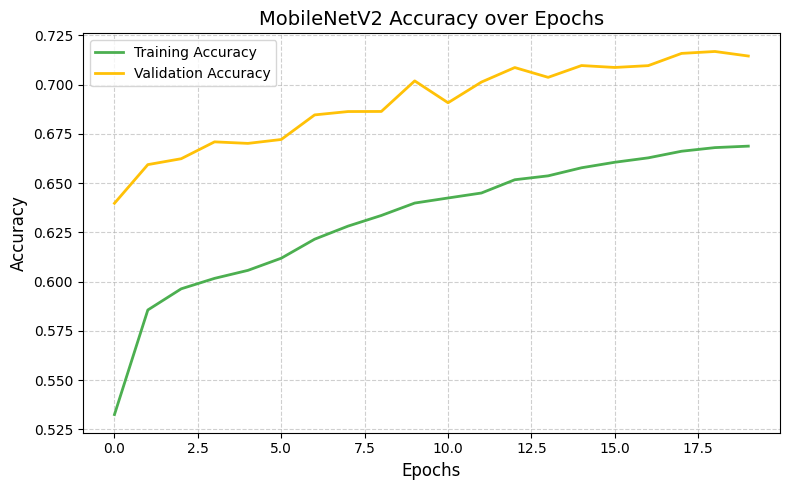

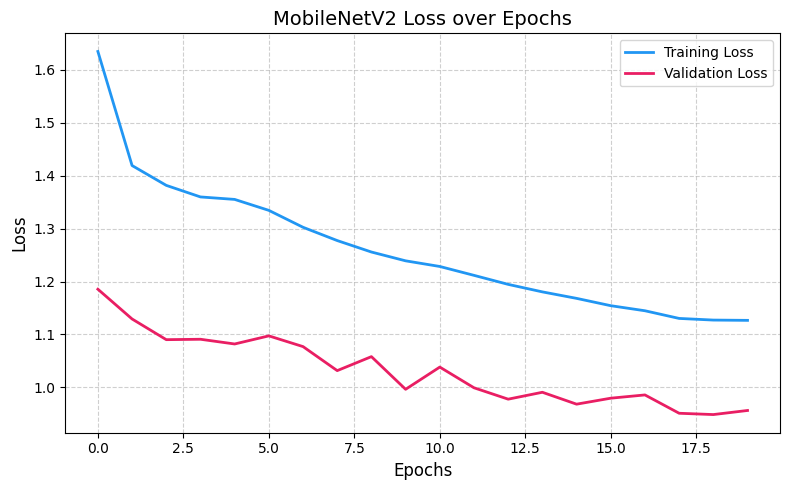

✅ MobileNetV2 training performance visualized successfully!


In [39]:
# ===================== 📊 Step 15: MobileNetV2 Training Performance Visualization =====================
import matplotlib.pyplot as plt

# ✅ Check if the 'history_mbn' variable exists
if 'history_mbn' in locals():
    history_dict = history_mbn.history

    # --- Accuracy Plot ---
    plt.figure(figsize=(8, 5))
    plt.plot(history_dict.get('accuracy', []), label='Training Accuracy', color='#4CAF50', linewidth=2)
    plt.plot(history_dict.get('val_accuracy', []), label='Validation Accuracy', color='#FFC107', linewidth=2)
    plt.title('MobileNetV2 Accuracy over Epochs', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # --- Loss Plot ---
    plt.figure(figsize=(8, 5))
    plt.plot(history_dict.get('loss', []), label='Training Loss', color='#2196F3', linewidth=2)
    plt.plot(history_dict.get('val_loss', []), label='Validation Loss', color='#E91E63', linewidth=2)
    plt.title('MobileNetV2 Loss over Epochs', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    print("✅ MobileNetV2 training performance visualized successfully!")
else:
    print("⚠️ 'history_mbn' variable not found. Please train the MobileNetV2 model before plotting.")


In [41]:
# ===================== 📊 Step 16: Data Drift Detection (Local Version) =====================
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, shutil, random

# ✅ 1️⃣ Create local temporary folder for simulated new data
base_project_path = "/content/drive/MyDrive/DeepLearningProject"
new_data_path = os.path.join(base_project_path, "new_test_data")

# Clean existing folder (if any)
if os.path.exists(new_data_path):
    shutil.rmtree(new_data_path)
os.makedirs(new_data_path, exist_ok=True)

# ✅ 2️⃣ Randomly copy a sample of 50 images from the merged dataset
all_images = [
    os.path.join(root, file)
    for root, _, files in os.walk(merged_path)
    for file in files
    if file.lower().endswith(('.png', '.jpg', '.jpeg'))
]

sample_images = random.sample(all_images, min(50, len(all_images)))  # Handles small datasets
for img_path in sample_images:
    shutil.copy(img_path, new_data_path)

print(f"✅ Created a sample of {len(sample_images)} new images at: {new_data_path}")

# ✅ 3️⃣ Load the new data using ImageDataGenerator
new_data_gen = ImageDataGenerator(rescale=1./255)
new_data_flow = new_data_gen.flow_from_directory(
    base_project_path,
    classes=["new_test_data"],
    target_size=(64, 64),  # ✅ Match your MobileNet input size
    batch_size=16,
    class_mode=None,
    shuffle=False
)

# ✅ 4️⃣ Compare pixel mean values between training data and new data
original_batch = next(train_set)[0]  # One batch from training
original_means = np.mean(original_batch, axis=(0, 1, 2))
new_means = np.mean(new_data_flow[0], axis=(0, 1, 2))
diff = np.abs(original_means - new_means)

print("\n--- 🌿 Data Drift Analysis ---")
print("Original Mean Pixel Values (RGB):", np.round(original_means, 4))
print("New Data Mean Pixel Values (RGB):", np.round(new_means, 4))
print("Absolute Difference:", np.round(diff, 4))

# ✅ 5️⃣ Drift threshold check
threshold = 0.05
if np.any(diff > threshold):
    print("⚠️ WARNING: Potential data drift detected! Consider retraining or fine-tuning the model.")
else:
    print("✅ No significant data drift detected.")

# ✅ 6️⃣ Cleanup temporary folder
shutil.rmtree(new_data_path)
print("🧹 Temporary new data folder removed successfully.")


✅ Created a sample of 50 new images at: /content/drive/MyDrive/DeepLearningProject/new_test_data
Found 50 images belonging to 1 classes.

--- 🌿 Data Drift Analysis ---
Original Mean Pixel Values (RGB): [0.2747 0.3421 0.2295]
New Data Mean Pixel Values (RGB): [0.2729 0.3125 0.1925]
Absolute Difference: [0.0018 0.0296 0.037 ]
✅ No significant data drift detected.
🧹 Temporary new data folder removed successfully.


✅ Loaded base model (MobileNetV2): Sequential
🎯 Targeting Grad-CAM layer: Conv_1
⚙️ Grad-CAM model built successfully.
🖼️ Image loaded and preprocessed: (1, 64, 64, 3)
🌿 Prediction (MobileNetV2): Tomato___Late_blight (28.31% confidence)


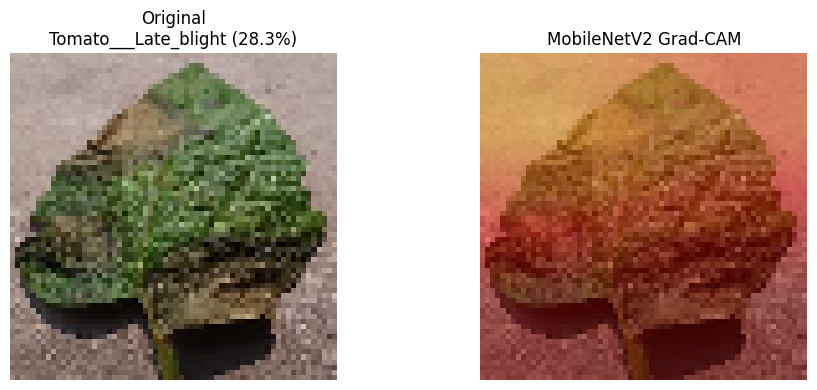

💾 Grad-CAM image saved at: /content/drive/MyDrive/DeepLearningProject/models/GradCAM_MobileNetV2_Tomato___Late_blight.jpg


In [47]:
# ===================== ✅ Step 18: Grad-CAM Visualization for MobileNetV2 =====================
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# ✅ 1️⃣ Load the trained MobileNetV2 model
base_model_mbn = load_model(mobilenet_model_path)
print("✅ Loaded base model (MobileNetV2):", base_model_mbn.__class__.__name__)

# ✅ 2️⃣ Extract MobileNetV2 backbone from Sequential model
mobilenet_layer = base_model_mbn.layers[0]  # MobileNetV2 base
mobilenet_layer.trainable = False

# ✅ 3️⃣ Find the last Conv2D (or activation) layer for Grad-CAM
last_conv_layer_name_mbn = None
for layer in reversed(mobilenet_layer.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        try:
            next_layer_index = mobilenet_layer.layers.index(layer) + 1
            next_layer = mobilenet_layer.layers[next_layer_index]
            if isinstance(next_layer, (tf.keras.layers.ReLU, tf.keras.layers.Activation)):
                last_conv_layer_name_mbn = next_layer.name
            else:
                last_conv_layer_name_mbn = layer.name
        except IndexError:
            last_conv_layer_name_mbn = layer.name
        break

if last_conv_layer_name_mbn is None:
    raise ValueError("❌ No Conv2D layer found in the MobileNetV2 base model.")

print(f"🎯 Targeting Grad-CAM layer: {last_conv_layer_name_mbn}")

# ✅ 4️⃣ Build functional Grad-CAM-compatible model
inp_mbn = mobilenet_layer.input
last_conv_output_mbn = mobilenet_layer.get_layer(last_conv_layer_name_mbn).output

x = mobilenet_layer.output
for layer in base_model_mbn.layers[1:]:
    x = layer(x)

grad_model_mbn = Model(inputs=inp_mbn, outputs=[last_conv_output_mbn, x])
print("⚙️ Grad-CAM model built successfully.")

# ✅ 5️⃣ Load and preprocess a test image
# --- FIX: Corrected path to match unzip location and previous test file ---
img_path_mbn_test = "/content/plantvillage/plantvillage dataset/color/Tomato___Late_blight/00355ec2-f12c-4015-b8f9-94354f69ce22___RS_Late.B 5311.JPG"

try:
    # --- FIX: Match target_size to your model's input shape (64, 64) ---
    orig_img = tf.keras.utils.load_img(img_path_mbn_test, target_size=(64, 64))
except FileNotFoundError:
    print(f"❌ Error: Test image not found at {img_path_mbn_test}")
    raise

orig_img_array = tf.keras.utils.img_to_array(orig_img)
img_array_mbn_test = np.expand_dims(orig_img_array / 255.0, axis=0)
print("🖼️ Image loaded and preprocessed:", img_array_mbn_test.shape)

# ✅ 6️⃣ Predict class
preds_mbn = base_model_mbn.predict(img_array_mbn_test, verbose=0)
pred_class_mbn = np.argmax(preds_mbn[0])
confidence_mbn = np.max(preds_mbn[0]) * 100

if 'train_set' not in locals() or not hasattr(train_set, 'class_indices'):
    raise NameError("❌ 'train_set' with class_indices not found. Please run the data generator cell first.")

class_indices_mbn = train_set.class_indices
inv_class_indices_mbn = {v: k for k, v in class_indices_mbn.items()}

pred_label_mbn = inv_class_indices_mbn.get(pred_class_mbn, "Unknown Class")
print(f"🌿 Prediction (MobileNetV2): {pred_label_mbn} ({confidence_mbn:.2f}% confidence)")

# ✅ 7️⃣ Compute Grad-CAM heatmap
img_tensor_mbn = tf.convert_to_tensor(img_array_mbn_test)
with tf.GradientTape() as tape:
    conv_outputs_mbn, predictions_mbn = grad_model_mbn(img_tensor_mbn, training=False)
    loss_mbn = predictions_mbn[:, pred_class_mbn]

grads_mbn = tape.gradient(loss_mbn, conv_outputs_mbn)
pooled_grads_mbn = tf.reduce_mean(grads_mbn, axis=(0, 1, 2))
conv_outputs_mbn = conv_outputs_mbn[0]
heatmap_mbn = tf.reduce_sum(tf.multiply(pooled_grads_mbn, conv_outputs_mbn), axis=-1)

# ✅ 8️⃣ Normalize and resize the heatmap
heatmap_mbn = np.maximum(heatmap_mbn, 0)
heatmap_mbn /= (np.max(heatmap_mbn) + 1e-8)
heatmap_resized_mbn = cv2.resize(heatmap_mbn, (orig_img_array.shape[1], orig_img_array.shape[0]))
heatmap_colored_mbn = cv2.applyColorMap(np.uint8(255 * heatmap_resized_mbn), cv2.COLORMAP_JET)

# ✅ 9️⃣ Overlay heatmap on original image
orig_bgr = cv2.cvtColor(orig_img_array.astype("uint8"), cv2.COLOR_RGB2BGR)
overlay = cv2.addWeighted(orig_bgr, 0.6, heatmap_colored_mbn, 0.4, 0)
overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# ✅ 🔟 Display Grad-CAM result
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(orig_img_array.astype("uint8"))
plt.title(f"Original\n{pred_label_mbn} ({confidence_mbn:.1f}%)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay_rgb)
plt.title("MobileNetV2 Grad-CAM")
plt.axis("off")
plt.tight_layout()
plt.show()

# ✅ 1️⃣1️⃣ Save Grad-CAM visualization
save_path_mbn_gradcam = os.path.join(model_save_dir, f"GradCAM_MobileNetV2_{pred_label_mbn.replace('/', '_').replace(' ', '')}.jpg")
cv2.imwrite(save_path_mbn_gradcam, cv2.cvtColor(overlay_rgb, cv2.COLOR_RGB2BGR))
print("💾 Grad-CAM image saved at:", save_path_mbn_gradcam)


✅ Both CNN and MobileNetV2 Grad-CAMs available for comparison.


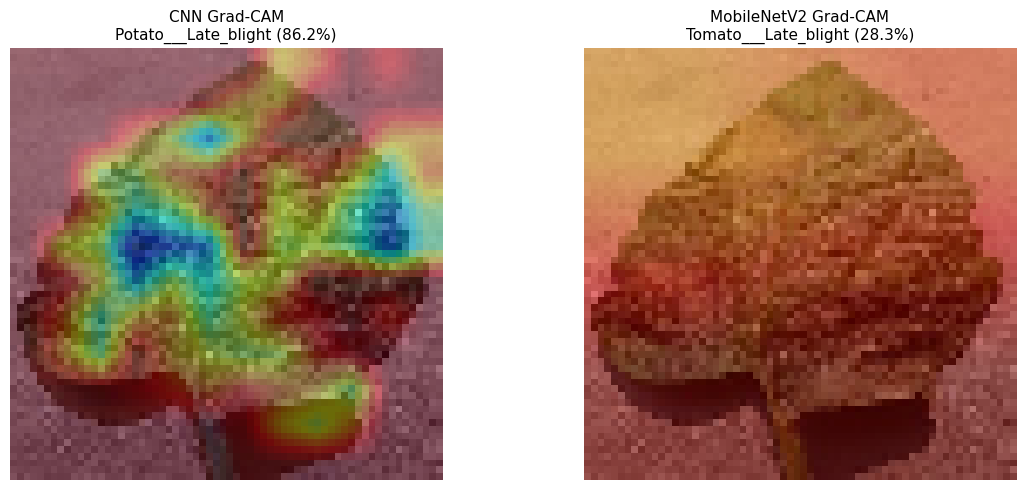

💾 Grad-CAM comparison saved at: /content/drive/MyDrive/DeepLearningProject/models/GradCAM_Comparison_Tomato___Late_blight.jpg


In [49]:
# ===================== ✅ Step 19: Grad-CAM Comparison (CNN vs MobileNetV2) =====================
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

# ✅ 1️⃣ Sanity check for required Grad-CAM variables
required_vars = ['overlay_rgb_cnn', 'overlay_rgb', 'pred_label_cnn', 'pred_label_mbn']
for var in required_vars:
    if var not in locals():
        raise NameError(f"❌ Missing variable: {var}. Please run both Grad-CAM cells first.")

print("✅ Both CNN and MobileNetV2 Grad-CAMs available for comparison.")

# ✅ 2️⃣ Create side-by-side visualization
plt.figure(figsize=(12, 5))

# --- Left: Custom CNN Grad-CAM ---
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(overlay_rgb_cnn, cv2.COLOR_BGR2RGB))
plt.title(f"CNN Grad-CAM\n{pred_label_cnn} ({confidence_cnn:.1f}%)", fontsize=11)
plt.axis("off")

# --- Right: MobileNetV2 Grad-CAM ---
plt.subplot(1, 2, 2)
plt.imshow(overlay_rgb)
plt.title(f"MobileNetV2 Grad-CAM\n{pred_label_mbn} ({confidence_mbn:.1f}%)", fontsize=11)
plt.axis("off")

plt.tight_layout()
plt.show()

# ✅ 3️⃣ Optional: Save comparison image
comparison_save_path = os.path.join(
    model_save_dir,
    f"GradCAM_Comparison_{pred_label_mbn.replace('/', '_').replace(' ', '')}.jpg"
)

# Stack the two overlays horizontally for saving
combined_overlay = np.hstack([
    cv2.cvtColor(overlay_rgb_cnn, cv2.COLOR_BGR2RGB),
    overlay_rgb
])
cv2.imwrite(comparison_save_path, cv2.cvtColor(combined_overlay, cv2.COLOR_RGB2BGR))

print("💾 Grad-CAM comparison saved at:", comparison_save_path)


--- Loading the BEST MobileNetV2 model for evaluation ---
Found 21707 images belonging to 38 classes.
--- Generating predictions for MobileNetV2 ---


1357/1357 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step

📊 Classification Report (MobileNetV2):

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab      0.531     0.302     0.385       252
                                 Apple___Black_rot      0.673     0.581     0.623       248
                          Apple___Cedar_apple_rust      0.677     0.191     0.298       110
                                   Apple___healthy      0.609     0.696     0.650       658
                               Blueberry___healthy      0.659     0.873     0.751       600
          Cherry_(including_sour)___Powdery_mildew      0.915     0.540     0.680       420
                 Cherry_(including_sour)___healthy      0.745     0.833     0.787       341
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot      0.692     0.439     0.537       205
                       Corn_(maize)___Common_rust_      0.781     0.926     0.847    

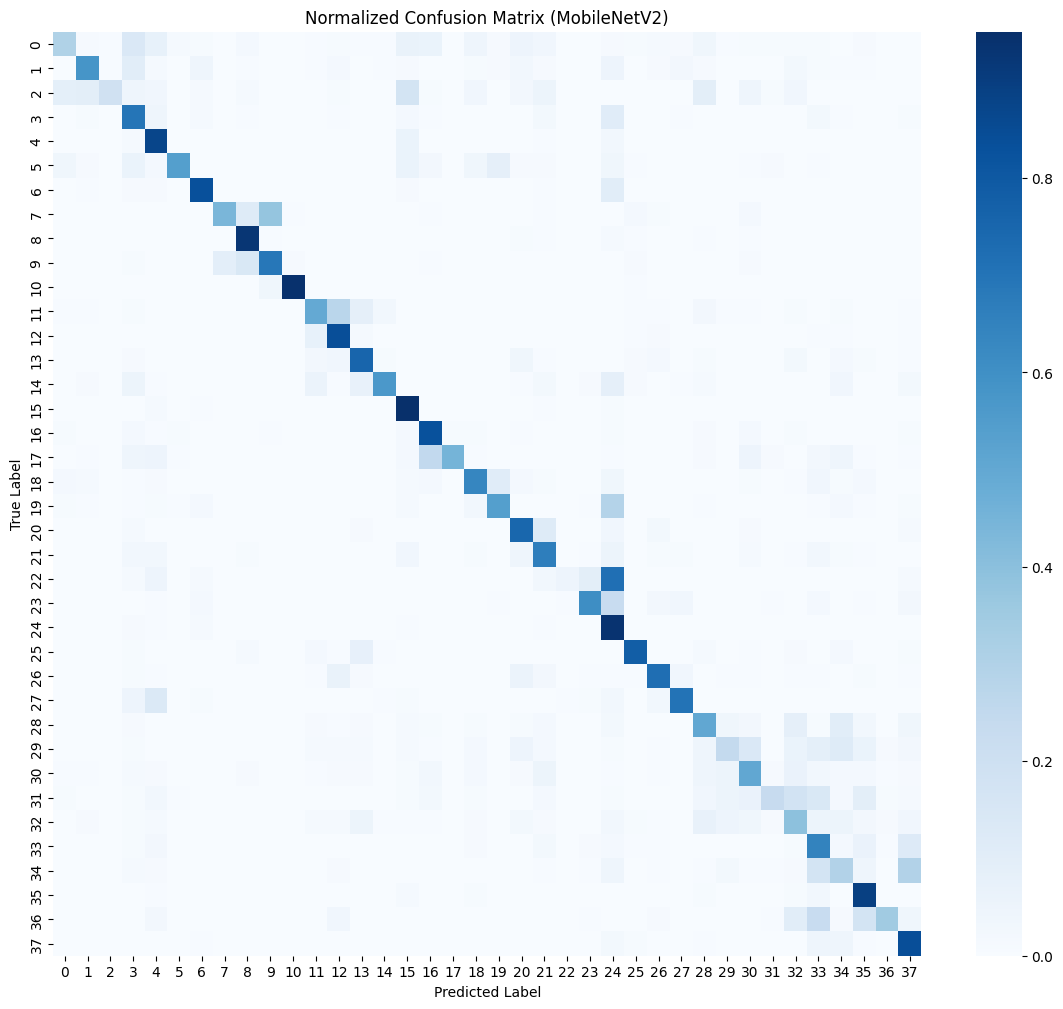

In [50]:
# ===================== 📊 Step 20: Full Evaluation for MobileNetV2 =====================
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Loading the BEST MobileNetV2 model for evaluation ---")
# Load the best saved model (mobilenet_model_path should be in memory)
model_mbn = load_model(mobilenet_model_path)

# 1. Create a non-shuffled generator for evaluation
# (We can re-use the 'eval_datagen' from our CNN evaluation)
eval_generator_mbn = eval_datagen.flow_from_directory(
    merged_path,
    target_size=(64, 64), # Must match the (64, 64) you trained MobileNet on
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# 2. Get predictions and true labels
print("--- Generating predictions for MobileNetV2 ---")
val_preds_mbn = model_mbn.predict(eval_generator_mbn, verbose=1)
y_pred_mbn = np.argmax(val_preds_mbn, axis=1)
y_true_mbn = eval_generator_mbn.classes
class_labels_mbn = list(eval_generator_mbn.class_indices.keys())

# 3. Print Classification Report
print("\n📊 Classification Report (MobileNetV2):\n")
report_mbn = classification_report(y_true_mbn, y_pred_mbn, target_names=class_labels_mbn, digits=3)
print(report_mbn)

# 4. Plot Normalized Confusion Matrix
print("\n📊 Confusion Matrix (MobileNetV2):")
cm_mbn = confusion_matrix(y_true_mbn, y_pred_mbn)
cm_normalized_mbn = cm_mbn.astype('float') / cm_mbn.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_normalized_mbn, cmap='Blues')
plt.title('Normalized Confusion Matrix (MobileNetV2)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()